In [5]:
%matplotlib inline
import os;
os.chdir('/Users/Sriram/Desktop/cars_com')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read Data

In [6]:
allData = pd.read_excel('Exercise_Data.xlsx',skiprows=1)

In [7]:
allData = allData.rename(columns = {'Unnamed: 0':'Date'}) # change col 1 name to date 

In [8]:
allData['Date'] = pd.to_datetime(allData['Date']) # change formate to datetime

In [9]:
# cerate diff month, day, year features
month = []; day = []; year = []; weekday = []

for date in allData.Date:
    
    month.append(str(date.month))
    day.append(str(date.day))
    year.append(str(date.year))
    weekday.append(date.weekday_name)

In [10]:
# add feats to orig data

allData['month'] = pd.Series(month)
allData['day'] = pd.Series(day)
allData['year'] = pd.Series(year)
allData['weekDay'] = pd.Series(weekday)

In [11]:
allData.head() # data preview

,Date,Visits_Wired,Visits_Mobile,Visits_Android,Visits_iPhone,Visits_iPad,Searches_Wired,Searches_Mobile,Searches_Android,Searches_iPhone,Searches_iPad,month,day,year,weekDay
0,2013-10-01,663616,82102,43066,70669,9371,603205,207509,109809,177803,27642,10,1,2013,Tuesday
1,2013-10-02,659590,81886,43215,70907,9450,605373,207762,109494,178450,27764,10,2,2013,Wednesday
2,2013-10-03,659920,81245,42616,70264,9655,593943,207426,105487,175142,29798,10,3,2013,Thursday
3,2013-10-04,623123,79156,42013,68734,9250,564645,196150,100003,167233,27618,10,4,2013,Friday
4,2013-10-05,601916,89296,45974,75589,12147,555258,233029,116572,192127,37152,10,5,2013,Saturday


In [12]:
allData.shape

(134, 15)

### Part 1: Data Exploration

#### You are told that around the time of Super Bowl 2014, some of the searches on Cars.com weren’t getting tracked correctly.
 
 -	**Which platforms weren’t logging searches correctly? For which days?**
 
Since we are looking at time-series data, we use amovign average to find outliers.

In [13]:
# detect outliers using a moving average and difference threshhold
def detectOutliers(series, thresh):
    
    outlierIndex = []
    
    average = 0
    
    for i, value in enumerate(series):
                    
        average = average + value/(i+1) # calc moving avg
        
        if abs((value - average)/average)  > thresh: # comp deviation from mv. avg.
            
            #print(abs(value - average)/average)
            outlierIndex.append(i)
        # print(average)
    
    return outlierIndex

In [14]:
# go through the list of search variables and find outliers
for colName in allData.columns:
    
    if 'Searches' in colName:
        
        outliers = detectOutliers(allData[colName], 0.95)
        
        if len(outliers) == 0: continue
        
        subData = allData.iloc[outliers,:]
        
        print('On the platform ', colName[9:], ' searches during the following dates were not logged properly: ')
        
        print(subData['Date'])

On the platform  Android  searches during the following dates were not logged properly: 
121   2014-01-30
122   2014-01-31
123   2014-02-01
124   2014-02-02
125   2014-02-03
126   2014-02-04
127   2014-02-05
128   2014-02-06
129   2014-02-07
130   2014-02-08
131   2014-02-09
Name: Date, dtype: datetime64[ns]
On the platform  iPhone  searches during the following dates were not logged properly: 
121   2014-01-30
122   2014-01-31
123   2014-02-01
124   2014-02-02
125   2014-02-03
126   2014-02-04
127   2014-02-05
128   2014-02-06
129   2014-02-07
130   2014-02-08
131   2014-02-09
Name: Date, dtype: datetime64[ns]
On the platform  iPad  searches during the following dates were not logged properly: 
121   2014-01-30
122   2014-01-31
123   2014-02-01
124   2014-02-02
125   2014-02-03
126   2014-02-04
127   2014-02-05
128   2014-02-06
129   2014-02-07
130   2014-02-08
131   2014-02-09
Name: Date, dtype: datetime64[ns]


ANSWER: Only searches on **Andriod, iPHone, iPad** had wrong logs. See above for the specific dates.

- **How do you know this? How would you show this using a graph?**

In [15]:
superBowlData = allData.query('20140124 < Date < 20140215') # query to subset data

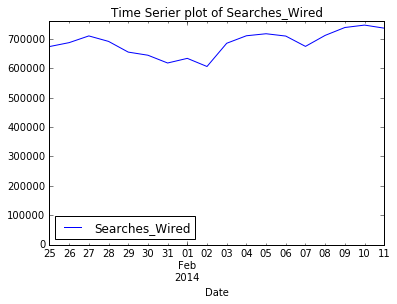

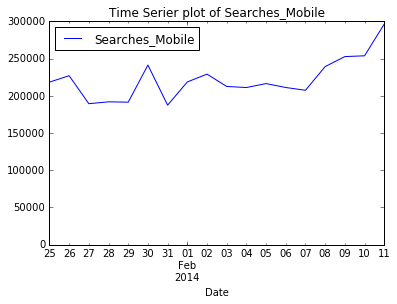

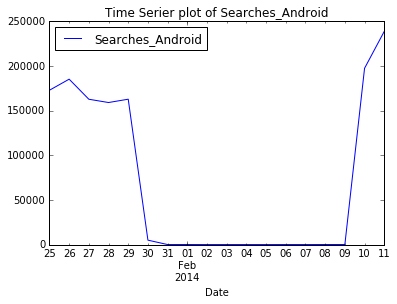

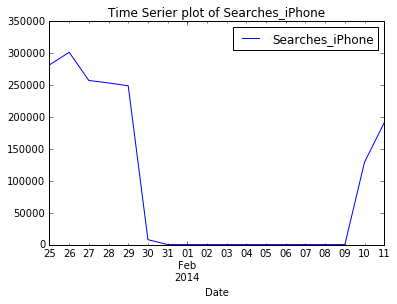

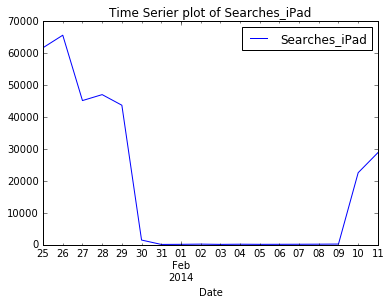

In [16]:
# time series to see how the values are trending with time

for colName in superBowlData.columns:
    
    if 'Searches' in colName:
    
        plt.show()
        
        superBowlData[['Date',colName]].set_index('Date').plot()
        
        title_ = 'Time Serier plot of ' + colName
        
        plt.ylim(0)
        
        plt.title(title_)

ANSWER: Based on the plots above, we can see that only searches on android, iphone, ipad show sudden drops during superbowl 2014

### PART 2: Linear Regression
#### For the days that aren’t logging correctly, you are tasked with figuring out what the search counts would have been for those days if they were getting tracked correctly. Since you are limited on time for this exercise, please only estimate search counts for the incorrectly tracked data for Searches via Android (column I).
- **Perform a linear regression to create a model to estimate the search counts. You can copy and paste your code in this Word doc.**

Only focusing on android due to lack of time

In [17]:
from sklearn.linear_model import LinearRegression

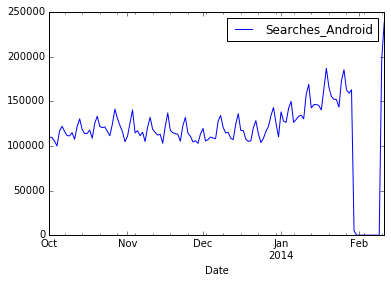

In [18]:
# Android currently
allData[['Date','Searches_Android']].set_index('Date').plot()

By the above plot, it is apparent that there is a lot of seasonality in the data. Hence we cannot simply regress over the dates, we neeed to perform regression over the days of the week and months of the year.

In [19]:
subData = allData[['Searches_Android', 'month','year','weekDay']]

data_wdummies = pd.get_dummies(subData)

iOutliers = detectOutliers(allData.Searches_Android, 0.95)

ignoreDF = allData.index.isin(iOutliers)
# only outliers and no search log values
toPredict = data_wdummies[ignoreDF]; del toPredict['Searches_Android'] 
noOutlierData = data_wdummies[~ignoreDF] # remove outlier rwws

# getting X and y
y = noOutlierData['Searches_Android']
X = noOutlierData; del noOutlierData['Searches_Android']

In [20]:
fit = LinearRegression().fit(X, y)
pred = fit.predict(toPredict); pred = pred.astype('int')

In [21]:
# predictions for outliers
pred

array([143275, 139405, 226321, 237091, 218920, 217371, 214805, 212569,
       208699, 226321, 237091])

In [22]:
# let us look at plot with values filled in
allData.ix[iOutliers,'Searches_Android'] = pred

(0, 240000.0)

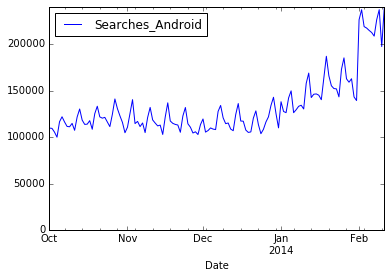

In [23]:
# plot
allData[['Date','Searches_Android']].set_index('Date').plot()
plt.ylim(0)

ANSWER: As seen above, we created a model and estimated the values of the wrong search logs.

- **How accurate is your model? How would you explain your results to a non-technical group?**

Due to the lack of time, I did not create a test-train split to estimate performance, instead, the perforamance has been estimated on the training data itself. 

In [24]:
from sklearn.metrics import r2_score

train_pred = fit.predict(X)

print('the r^2 value of this model is ', r2_score(y, train_pred))

the r^2 value of this model is  0.866019105176


This means that our model is able to account of 87% of the variation in our data.

**To a non-technical person:** Using linear regression we are able to predict the values of the incorrectly logged values with high confidence (close to 90%) based on the historical trends found in the Android search logs

### Part 3: Discussion
#### After taking a first pass at the analysis, what thoughts do you have on next steps?
- **What are some concerns you have about the current model?**

** Some concerns about the current model: **

- The current model used to fill in the incorrect entries has undergone no parameter tuning. 
- The outlier detector was too forgiving since we set a treshold of 95% (deviation from moving average)... there might be certain less-obvious outliers that we failed to detect. 
- the R^2 value provided is only based on the training data -- which means that it is likely an overestimation. 

- **What other methods would you potentially use to create a better model?**

** Other methods that can be used to create a better model **
- Robust regression techniques such as Huber regression might turn out to be a better fit then linear regression.
- Since the searches on mobile and wired worked fine, we could regress the searches on andriod with those on mobile and fill in the missing values 
- Fill in with the moving average
- Ensemble regressors, such as a Random Forest regressor, are likely to create a more accurate model
- We did capture the seasonlity as far the days of the week and month goes, however, it might make sense to also factor in the seasons, summer, winter, spring etc. There would likely be an impact from the season given that car sales vary by season as well. 